In [1]:
# let us import all the libraries
# to handle datasets
import numpy as np
import pandas as pd
# for plotting
import matplotlib.pyplot as plt
# to divide train and test set
from sklearn.model_selection import train_test_split
# feature scaling
from sklearn.preprocessing import MinMaxScaler
#to buid models
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
# models for Stacking
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
# to evaluate the model
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error,r2_score
import math
#to find training time of the model
import time
# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)
import warnings
warnings.simplefilter(action='ignore')

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [3]:
# Let's separate into train and test set
# Remember to set the seed (random_state for this sklearn function)
X_train, X_test, y_train, y_test = train_test_split(train_df,train_df['Hardness'],test_size=0.25,
                                                     random_state=42) 
X_train.shape, X_test.shape

((7805, 13), (2602, 13))

In [4]:
# capture all variables in a list
# except the target and the ID
train_vars = [var for var in X_train.columns if var not in ['id', 'Hardness']]
# create scaler
scaler = MinMaxScaler()
#  fit  the scaler to the train set
scaler.fit(X_train[train_vars]) 
# transform the train and test set
X_train[train_vars] = scaler.transform(X_train[train_vars])
X_test[train_vars] = scaler.transform(X_test[train_vars])
test_df[train_vars] = scaler.transform(test_df[train_vars])
print(X_train.isnull().sum().any(),X_test.isnull().sum().any())

False False


In [5]:
X_train.head()

,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
8667,8667,0.007843,0.036662,0.179104,0.800000,0.143880,0.746545,0.816149,0.773333,0.532231,0.596642,0.112046,6.0
8648,8648,0.009412,0.035622,0.214925,0.866667,0.186409,0.707681,0.779553,0.826222,0.571220,0.592346,0.353064,3.8
7675,7675,0.004967,0.023993,0.313433,0.666667,0.259848,0.614620,0.683125,0.835556,0.683236,0.578294,0.197665,3.8
4156,4156,0.010196,0.015875,0.171642,0.805556,0.134884,0.712220,0.811211,0.760000,0.568848,0.580745,0.057416,5.3
8844,8844,0.028758,0.067659,0.142764,0.797101,0.115668,0.720776,0.788746,0.761643,0.536536,0.593352,0.072543,7.0


In [6]:
sel_= SelectFromModel(Lasso(alpha=0.005,random_state=0))
# train Lasso model and select features
sel_.fit(X_train,y_train)
# let's print the number of total and selected features
selected_feats = X_train.columns[(sel_.get_support())]
# let's print some stats
print('Total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feats)))
print('features with coefficients shrank to zero: {}'.format(np.sum(sel_.estimator_.coef_== 0)))

Total features: 13
selected features: 1
features with coefficients shrank to zero: 11


In [7]:
# #let's look at the feature importance
# importance = pd.Series(np.abs(lin_model.coef_.ravel()))
# importance.index = selected_feats
# importance.sort_values(inplace=True, ascending=False)
# importance.plot.bar(figsize=(10,6))
# plt.ylabel('Lasso Coefficients')
# plt.title('Feature Importance')

In [8]:
X_train=X_train.drop(["id","Hardness"],axis = 1)
X_test=X_test.drop(["id","Hardness"],axis = 1)
print(X_train.shape,X_test.shape)

(7805, 11) (2602, 11)


In [9]:
y_test

3952    5.5
4597    7.0
9621    2.5
8620    6.8
4294    2.5
       ... 
2545    3.8
5467    5.0
8671    6.0
9899    5.8
1918    6.0
Name: Hardness, Length: 2602, dtype: float64

In [10]:
X_train.head()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average
8667,0.007843,0.036662,0.179104,0.800000,0.143880,0.746545,0.816149,0.773333,0.532231,0.596642,0.112046
8648,0.009412,0.035622,0.214925,0.866667,0.186409,0.707681,0.779553,0.826222,0.571220,0.592346,0.353064
7675,0.004967,0.023993,0.313433,0.666667,0.259848,0.614620,0.683125,0.835556,0.683236,0.578294,0.197665
4156,0.010196,0.015875,0.171642,0.805556,0.134884,0.712220,0.811211,0.760000,0.568848,0.580745,0.057416
8844,0.028758,0.067659,0.142764,0.797101,0.115668,0.720776,0.788746,0.761643,0.536536,0.593352,0.072543


In [11]:
# The parameters inside the models can be varied 
params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'quantile'}
GB_model= GradientBoostingRegressor(**params) 
lin_model = Lasso(alpha=0.005, random_state=0)
RF_model = RandomForestRegressor(n_estimators=400,random_state=0)
# Get these models in a list
estimators = [('Random Forest', RF_model),
              ('Lasso', lin_model),
              ('Gradient Boosting', GB_model)]
#Stack these models with StackingRegressor
stacking_regressor = StackingRegressor(estimators=estimators,
                                       final_estimator=RidgeCV())

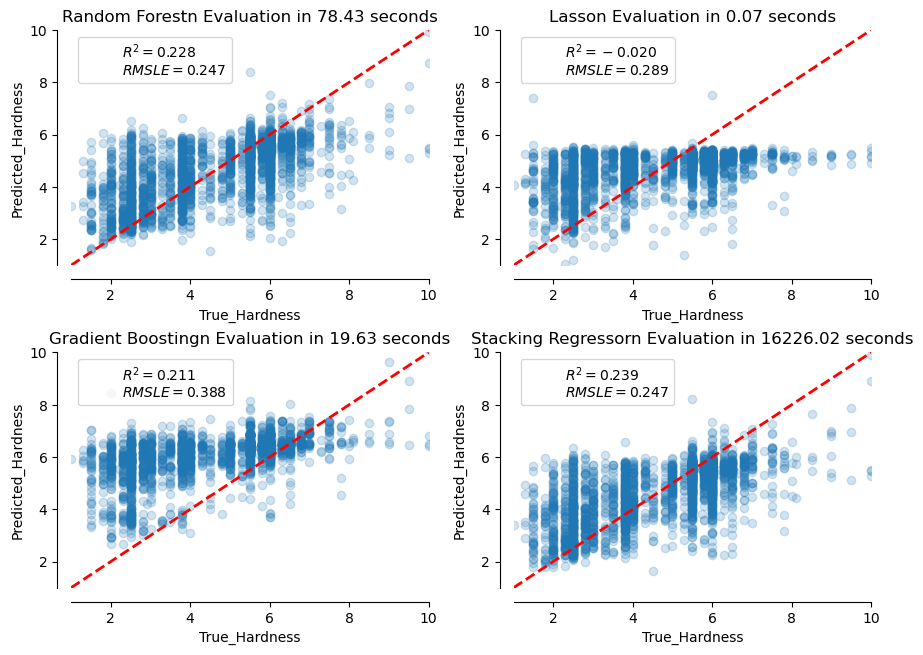

In [12]:
def plot_regression_results(ax, y_true, y_pred, title, scores, elapsed_time):
    """Scatter plot of the predicted vs true targets."""
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('True_Hardness')
    ax.set_ylabel('Predicted_Hardness')
    extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False,
                          edgecolor='none', linewidth=0)
    ax.legend([extra], [scores], loc='upper left')
    title = title + 'n Evaluation in {:.2f} seconds'.format(elapsed_time)
    ax.set_title(title)
fig, axs = plt.subplots(2, 2, figsize=(9, 7))
axs = np.ravel(axs)
errors_list=[]
for ax, (name, est) in zip(axs, estimators + [('Stacking Regressor',
                                               stacking_regressor)]):
    start_time = time.time()
    model = est.fit(X_train, y_train)
                     
    elapsed_time = time.time() - start_time
    
    pred = model.predict(X_test)
    errors = y_test - model.predict(X_test)
    errors_list.append(errors)
    test_r2= r2_score(np.exp(y_test), np.exp(pred))
    
    test_rmsle=math.sqrt(mean_squared_log_error(y_test,pred))
    plot_regression_results(ax,y_test,pred,name,(r'$R^2={:.3f}$' + '\n' + 
                            r'$RMSLE={:.3f}$').format(test_r2,test_rmsle),elapsed_time)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

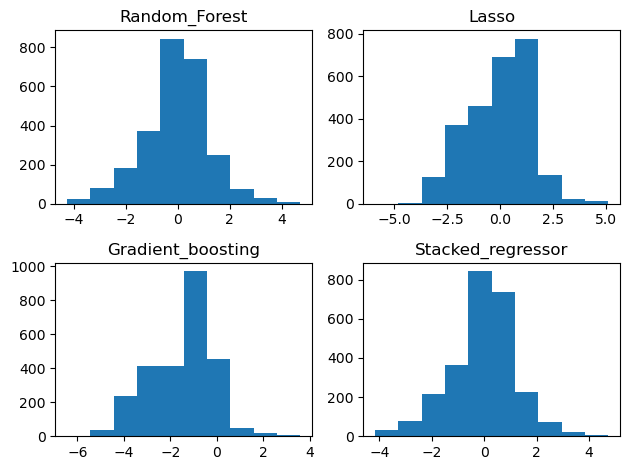

In [13]:
titles = ['Random_Forest','Lasso','Gradient_boosting','Stacked_regressor'] 
f,a = plt.subplots(2,2)
a = a.ravel()
for idx,ax in enumerate(a):
    ax.hist(errors_list[idx])
    ax.set_title(titles[idx])
plt.tight_layout()

In [14]:
# #let's look at the feature importance
# importance = pd.Series(np.abs(lin_model.coef_.ravel()))
# importance.index = selected_feats
# importance.sort_values(inplace=True, ascending=False)
# importance.plot.bar(figsize=(10,6))
# plt.ylabel('Lasso Coefficients')
# plt.title('Feature Importance')

In [15]:
pred

array([5.81650809, 4.98734407, 2.72489693, ..., 5.69872915, 5.93089222,
       5.73867024])

In [16]:
# RF = pd.DataFrame({'id': test_df["id"], 'Hardness': pred})
# RF.to_csv('submit22.csv', index=False)

In [17]:
test_df.head()

,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average
0,10407,0.057778,0.188806,0.527761,0.880000,0.493197,0.614620,0.667441,0.847644,0.742648,0.559207,0.163591
1,10408,0.005882,0.015444,0.268657,0.933333,0.236368,0.792762,0.832994,0.734222,0.534706,0.576515,0.128709
2,10409,0.007582,0.012079,0.173134,0.800000,0.138780,0.723073,0.767935,0.797333,0.594118,0.604746,0.071863
3,10410,0.006536,0.014163,0.149254,0.800000,0.121260,0.792762,0.821377,0.738667,0.490148,0.600244,0.109814
4,10411,0.003595,0.006267,0.164179,0.666667,0.137262,0.739938,0.713041,0.777778,0.552860,0.576393,0.085192


In [18]:
test_df[train_vars] = scaler.fit_transform(test_df[train_vars])
test_df.head()

,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average
0,10407,0.087386,0.188806,0.527761,0.880000,0.493197,0.614620,0.667441,0.847644,0.742881,0.559207,0.163591
1,10408,0.008897,0.015444,0.268657,0.933333,0.236368,0.792762,0.832994,0.734222,0.534874,0.576515,0.128709
2,10409,0.011467,0.012079,0.173134,0.800000,0.138780,0.723073,0.767935,0.797333,0.594305,0.604746,0.071863
3,10410,0.009885,0.014163,0.149254,0.800000,0.121260,0.792762,0.821377,0.738667,0.490301,0.600244,0.109814
4,10411,0.005437,0.006267,0.164179,0.666667,0.137262,0.739938,0.713041,0.777778,0.553033,0.576393,0.085192


In [19]:
test_id = test_df["id"]
test_df.drop("id",axis=1,inplace=True)

In [21]:
# test_id = test_df["id"]
# test_df.drop("id",axis=1,inplace=True)
pred_sub = stacking_regressor.predict(test_df)
pred_sub

array([2.77886637, 2.96797005, 5.77674109, ..., 5.34432225, 3.77246486,
       2.79889463])

In [22]:
pred = stacking_regressor.predict(X_test)

In [23]:
from sklearn.metrics import median_absolute_error

In [24]:
median_absolute_error(pred,y_test)

0.6795334968761466

In [25]:
RF = pd.DataFrame({'id': test_id , 'Hardness': pred_sub})
RF.to_csv('subm.csv', index=False)

In [26]:
RF.head()

,id,Hardness
0,10407,2.778866
1,10408,2.967970
2,10409,5.776741
3,10410,4.313830
4,10411,5.120364


In [27]:
pred_2 = lin_model.predict(X_test)

In [28]:
lin_pred = lin_model.predict(X_test)

In [29]:
median_absolute_error(pred_2,y_test)

0.9835791785250314

In [30]:
GB_pred = GB_model.predict(X_test)
median_absolute_error(GB_pred,y_test)

1.1253458534326515

In [31]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [32]:
xgb = XGBRegressor()
lgbm = LGBMRegressor()
cat = CatBoostRegressor()

In [33]:
xgb.fit(X_train,y_train)
pred = xgb.predict(X_test)

In [34]:
median_absolute_error(pred,y_test)

0.7068079948425292

In [35]:
lgbm.fit(X_train,y_train)
pred = lgbm.predict(X_test)
median_absolute_error(pred,y_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2456
[LightGBM] [Info] Number of data points in the train set: 7805, number of used features: 11
[LightGBM] [Info] Start training from score 4.655605


0.6561898215134501

In [36]:
cat.fit(X_train,y_train)
pred = cat.predict(X_test)
median_absolute_error(pred,y_test)

Learning rate set to 0.056647
0:	learn: 1.6635738	total: 236ms	remaining: 3m 56s
1:	learn: 1.6362827	total: 245ms	remaining: 2m 2s
2:	learn: 1.6089106	total: 253ms	remaining: 1m 23s
3:	learn: 1.5846761	total: 261ms	remaining: 1m 4s
4:	learn: 1.5617216	total: 268ms	remaining: 53.3s
5:	learn: 1.5410938	total: 274ms	remaining: 45.3s
6:	learn: 1.5206111	total: 279ms	remaining: 39.6s
7:	learn: 1.5019973	total: 285ms	remaining: 35.3s
8:	learn: 1.4859564	total: 292ms	remaining: 32.1s
9:	learn: 1.4712153	total: 299ms	remaining: 29.6s
10:	learn: 1.4565979	total: 313ms	remaining: 28.1s
11:	learn: 1.4425684	total: 319ms	remaining: 26.3s
12:	learn: 1.4320165	total: 327ms	remaining: 24.8s
13:	learn: 1.4209026	total: 335ms	remaining: 23.6s
14:	learn: 1.4104416	total: 340ms	remaining: 22.3s
15:	learn: 1.4007413	total: 347ms	remaining: 21.3s
16:	learn: 1.3920485	total: 353ms	remaining: 20.4s
17:	learn: 1.3833740	total: 358ms	remaining: 19.6s
18:	learn: 1.3750870	total: 365ms	remaining: 18.8s
19:	learn

0.6581421745755311

In [37]:
pred_sub = cat.predict(test_df)
pred_sub
RF = pd.DataFrame({'id': test_id , 'Hardness': pred_sub})
RF.to_csv('subm_new.csv', index=False)

In [38]:
pred_sub = lgbm.predict(test_df)
pred_sub
RF = pd.DataFrame({'id': test_id , 'Hardness': pred_sub})
RF.to_csv('lgbm_sub.csv', index=False)

In [39]:
pred_sub = xgb.predict(test_df)
pred_sub
RF = pd.DataFrame({'id': test_id , 'Hardness': pred_sub})
RF.to_csv('xgb_new.csv', index=False)

In [40]:
stacking_regressor = StackingRegressor(estimators=estimators,
                                       final_estimator=RidgeCV())

In [41]:
# The parameters inside the models can be varied 
params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'quantile'}
GB_model= GradientBoostingRegressor(**params) 
lin_model = Lasso(alpha=0.005, random_state=0)
RF_model = RandomForestRegressor(n_estimators=400,random_state=0)
# Get these models in a list
estimators = [('Random Forest', RF_model),
              ('Lasso', lin_model),
              ('Light GBoost', lgbm),
             ('Cat GBoost', cat)]
#Stack these models with StackingRegressor
stacking_regressor = StackingRegressor(estimators=estimators,
                                       final_estimator=RidgeCV())

In [42]:
stacking_regressor.fit(X_train,y_train)
pred = stacking_regressor.predict(X_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2456
[LightGBM] [Info] Number of data points in the train set: 7805, number of used features: 11
[LightGBM] [Info] Start training from score 4.655605
Learning rate set to 0.056647
0:	learn: 1.6635738	total: 6.68ms	remaining: 6.67s
1:	learn: 1.6362827	total: 12.3ms	remaining: 6.12s
2:	learn: 1.6089106	total: 17.6ms	remaining: 5.86s
3:	learn: 1.5846761	total: 23.1ms	remaining: 5.75s
4:	learn: 1.5617216	total: 28.7ms	remaining: 5.72s
5:	learn: 1.5410938	total: 34.1ms	remaining: 5.65s
6:	learn: 1.5206111	total: 39.6ms	remaining: 5.62s
7:	learn: 1.5019973	total: 46.5ms	remaining: 5.76s
8:	learn: 1.4859564	total: 51.8ms	remaining: 5.71s
9:	learn: 1.4712153	total: 57.1ms	remaining: 5.66s
10:	learn: 1.4565979	total: 62.4ms	remaining: 5.61s
11:	learn: 1.4425684	total: 67.7ms	remaining: 5.58s
12:	learn: 1.43

In [43]:
pred

array([5.9482224 , 5.04381374, 2.91559808, ..., 5.77168368, 6.07784867,
       5.88242311])

In [44]:
median_absolute_error(y_test,pred)

0.6593813380371629

In [45]:
pred = stacking_regressor.predict(test_df)

In [46]:
pred_sub = stacking_regressor.predict(test_df)
pred_sub
RF = pd.DataFrame({'id': test_id , 'Hardness': pred})
RF.to_csv('subm_new2.csv', index=False)

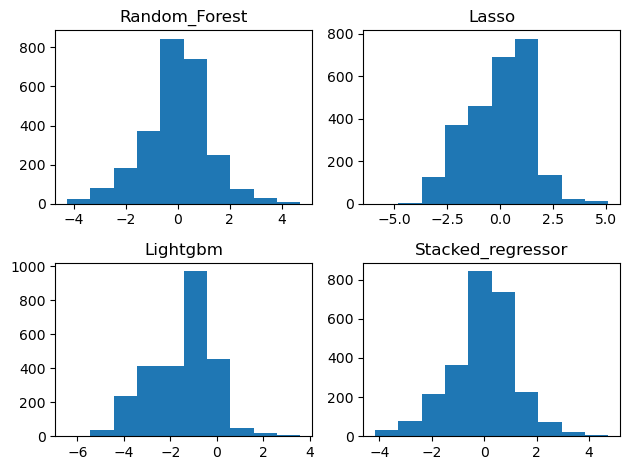

In [47]:
titles = ['Random_Forest','Lasso','Lightgbm','Stacked_regressor'] 
f,a = plt.subplots(2,2)
a = a.ravel()
for idx,ax in enumerate(a):
    ax.hist(errors_list[idx])
    ax.set_title(titles[idx])
plt.tight_layout()